In [23]:
import numpy as np
import pandas as pd

In [24]:
Data = pd.read_csv('https://raw.githubusercontent.com/Mieggy/face-gender-classify/main/gender_classification.csv')

In [25]:
Data = Data.replace('Male', 1)
Data = Data.replace('Female', -1)
Data

,long_hair,forehead_width_cm,forehead_height_cm,nose_wide,nose_long,lips_thin,distance_nose_to_lip_long,gender
0,1,11.8,6.1,1,0,1,1,1
1,0,14.0,5.4,0,0,1,0,-1
2,0,11.8,6.3,1,1,1,1,1
3,0,14.4,6.1,0,1,1,1,1
4,1,13.5,5.9,0,0,0,0,-1
...,...,...,...,...,...,...,...,...
4996,1,13.6,5.1,0,0,0,0,-1
4997,1,11.9,5.4,0,0,0,0,-1
4998,1,12.9,5.7,0,0,0,0,-1
4999,1,13.2,6.2,0,0,0,0,-1


In [53]:
X = Data.iloc[: ,: -1]
#X
y = Data.iloc[: ,-1:]
#y

In [54]:
X = X.values
y = y.values

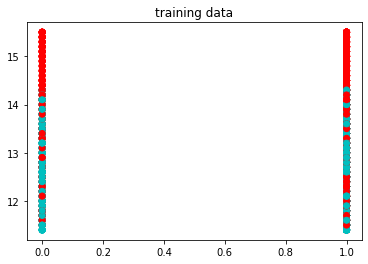

In [55]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt 
from sklearn.svm import LinearSVC

x_eval = X[:1000,:]
y_eval  = y[:1000,:]

x_train = X[1000:,:]
y_train = y[1000:,:]

n_eval = np.size(y_eval)
n_train = np.size(y_train)

plt.scatter(x_train[:,0],x_train[:,1], color=['c' if i==-1 else 'r' for i in y_train[:,0]])
plt.title('training data')
plt.show()

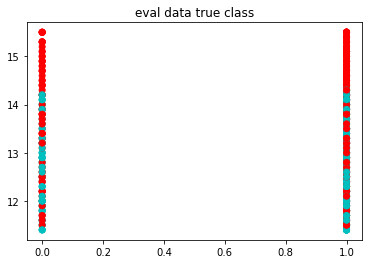

In [56]:
plt.scatter(x_eval[:,0],x_eval[:,1], color=['c' if i==-1 else 'r' for i in y_eval[:,0]])
plt.title('eval data true class')
plt.show()

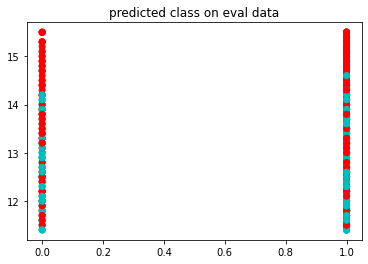

classifier weight is
[[-0.0288541 ]
 [ 0.05071584]
 [ 0.09615035]
 [ 0.57211291]
 [ 0.51774622]
 [ 0.51989364]
 [ 0.54946535]
 [-2.29150659]]


In [57]:
## least square classifier 
x_train_1 = np.hstack(( x_train, np.ones((n_train,1)) ))
x_eval_1 = np.hstack(( x_eval, np.ones((n_eval,1)) ))

w_opt = np.linalg.inv(x_train_1.T@x_train_1)@x_train_1.T@y_train  

y_hat_outlier = np.sign(x_eval_1@w_opt)
plt.scatter(x_eval[:,0],x_eval[:,1], color=['c' if i==-1 else 'r' for i in y_hat_outlier[:,0]])
plt.title('predicted class on eval data')
plt.show()

print('classifier weight is')
print(w_opt)

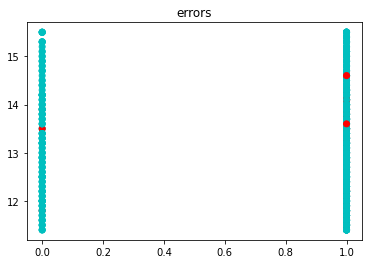

Errors: 39


In [58]:
error_vec = [0 if i[0]==i[1] else 1 for i in np.hstack((y_hat_outlier, y_eval))]
plt.scatter(x_eval[:,0],x_eval[:,1], color=['c' if i==0 else 'r' for i in error_vec])
plt.title('errors')
plt.show()

print('Errors: '+ str(sum(error_vec)))

In [62]:
lambda_value = np.logspace(-6,3,10)
x_train_1 = np.hstack(( x_train, np.ones((n_train,1)) ))
x_eval_1 = np.hstack(( x_eval, np.ones((n_eval,1)) ))
for r in range(lambda_value.shape[0]):
    w = ista_solve_hot(x_train_1,y_train,lambda_value)  
    err =np.mean(np.sign(x_eval_1@w[:,i:i+1])!=y_eval)
    print(r, err)

0 0.056
1 0.056
2 0.056
3 0.056
4 0.056
5 0.056
6 0.056
7 0.056
8 0.056
9 0.056


In [32]:
import numpy as np
import scipy.io as sio
err_sum=0
for i in range(5):
    for j in range(5):
        if i==j:continue
        test_idx_1=np.arange(i*1000,(i+1)*1000)
        test_idx_2=np.arange(j*1000,(j+1)*1000)
        train_idx=np.setdiff1d(np.arange(5000),test_idx_1)
        train_idx=np.setdiff1d(train_idx,test_idx_2)
        X_train,y_train=X[train_idx,:],y[train_idx,:]
        X_test_1,y_test_1=X[test_idx_1,:],y[test_idx_1,:]
        X_test_2,y_test_2=X[test_idx_2,:],y[test_idx_2,:]
        min_err,min_r,min_w=np.inf,-1,None
        w = np.linalg.inv(X_train.T@X_train)@X_train.T@y_train  
        err_=np.mean(np.sign(X_test_1@w)!=y_test_1)
        if err_<min_err:
            min_err,min_r,min_w=err_,r,w
        err_sum+=np.mean(np.sign(X_test_2@min_w)!=y_test_2)
print(err_sum/5/4)

0.05125000000000002


In [48]:
def ista_solve_hot( A, d, la_array ):
    # ista_solve_hot: Iterative soft-thresholding for multiple values of
    # lambda with hot start for each case - the converged value for the previous
    # value of lambda is used as an initial condition for the current lambda.
    # this function solves the minimization problem
    # Minimize |Ax-d|_2^2 + lambda*|x|_1 (Lasso regression)
    # using iterative soft-thresholding.
    max_iter = 10**4
    tol = 10**(-3)
    tau = 1/np.linalg.norm(A,2)**2
    n = A.shape[1]
    w = np.zeros((n,1))
    num_lam = len(la_array)
    X = np.zeros((n, num_lam))

    for i, each_lambda in enumerate(la_array):
        for j in range(max_iter):
            z = w - tau*(A.T@(A@w-d))
            w_old = w
            w = np.sign(z) * np.clip(np.abs(z)-tau*each_lambda/2, 0, np.inf)
            X[:, i:i+1] = w
            if np.linalg.norm(w - w_old) < tol:
                break

    return X

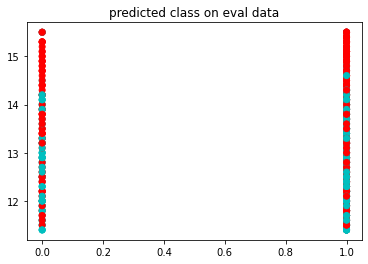

classifier weight is
[[-0.0288541 ]
 [ 0.05071584]
 [ 0.09615035]
 [ 0.57211291]
 [ 0.51774622]
 [ 0.51989364]
 [ 0.54946535]
 [-2.29150659]]


In [64]:
## LASSO classifier
lambda_value = np.logspace(-6,3)

x_train_1 = np.hstack(( x_train, np.ones((n_train,1)) ))
x_eval_1 = np.hstack(( x_eval, np.ones((n_eval,1)) ))
 
w = ista_solve_hot(x_train_1,y_train,lambda_value)  

y_hat_outlier = np.sign(x_eval_1@w[:,0:0+1])
plt.scatter(x_eval[:,0],x_eval[:,1], color=['c' if i==-1 else 'r' for i in y_hat_outlier[:,0]])
plt.title('predicted class on eval data')
plt.show()

print('classifier weight is')
print(w_opt)

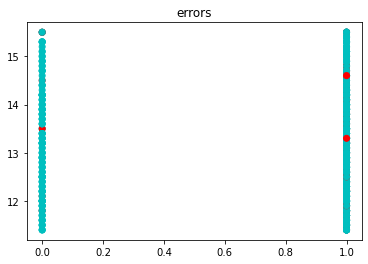

Errors: 56


In [65]:
error_vec = [0 if i[0]==i[1] else 1 for i in np.hstack((y_hat_outlier, y_eval))]
plt.scatter(x_eval[:,0],x_eval[:,1], color=['c' if i==0 else 'r' for i in error_vec])
plt.title('errors')
plt.show()

print('Errors: '+ str(sum(error_vec)))

In [37]:
import numpy as np
import scipy.io as sio
err_sum=0
lambda_value = np.logspace(-6,3)
for i in range(5):
    for j in range(5):
        if i==j:continue
        test_idx_1=np.arange(i*1000,(i+1)*1000)
        test_idx_2=np.arange(j*1000,(j+1)*1000)
        train_idx=np.setdiff1d(np.arange(5000),test_idx_1)
        train_idx=np.setdiff1d(train_idx,test_idx_2)
        X_train,y_train=X[train_idx,:],y[train_idx,:]
        X_test_1,y_test_1=X[test_idx_1,:],y[test_idx_1,:]
        X_test_2,y_test_2=X[test_idx_2,:],y[test_idx_2,:]
        min_err,min_r,min_w=np.inf,-1,None
        for r in range(lambda_value.shape[0]):
            w = ista_solve_hot(X_train,y_train,lambda_value)  
            err_=np.mean(np.sign(X_test_1@w[:,r:r+1])!=y_test_1)
            if err_<min_err:
                min_err,min_r,min_w=err_,r,w[:,r:r+1]
        err_sum+=np.mean(np.sign(X_test_2@min_w)!=y_test_2)
        
        
print(err_sum/5/4)

0.052900000000000016
